# Forecast Arctic sea ice cover

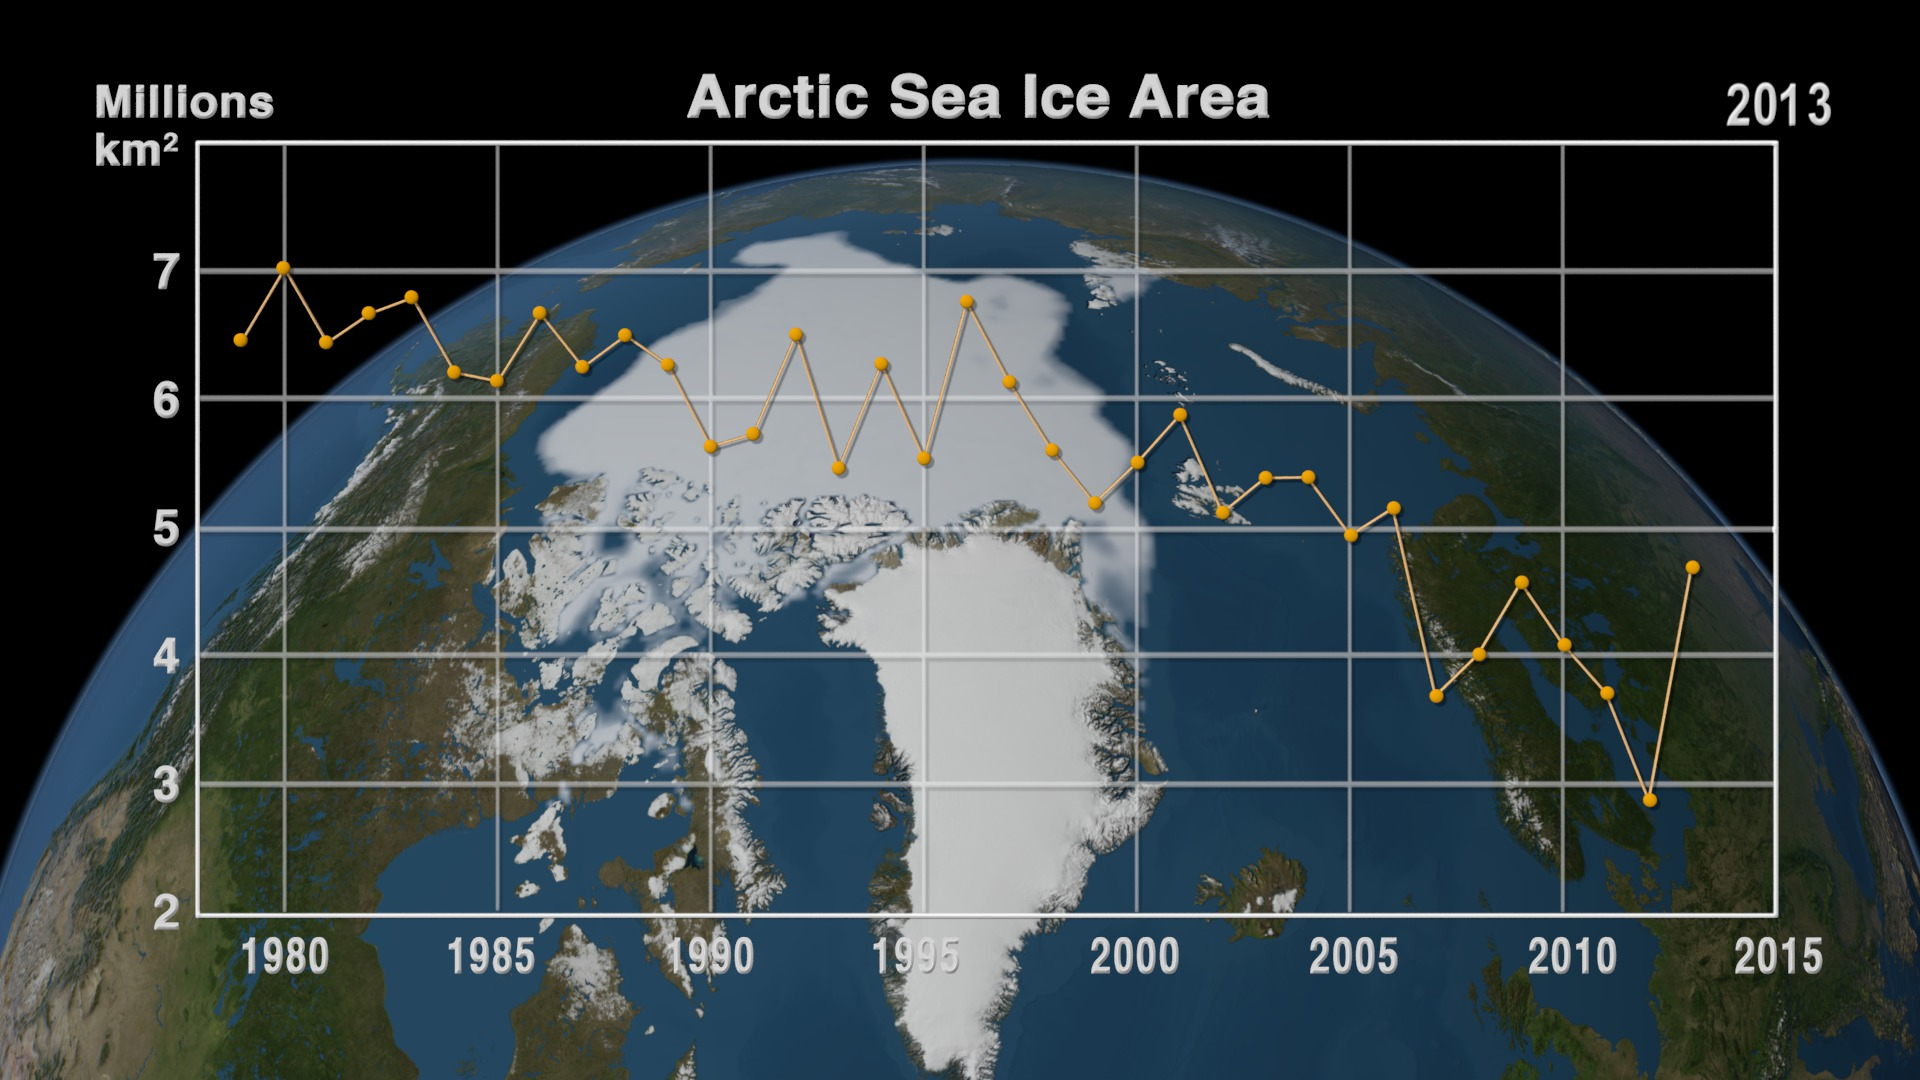

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from models.keras_models import CNNIce, CNNIce1
from tensorflow.keras.optimizers import SGD, Adam
from utils.utils import r_squared, PreProc

In [2]:
X_ds = xr.open_dataset('./data/Ice/train.nc')
y_array = np.load('./data/Ice/train.npy') 

In [3]:
X_ds

<xarray.Dataset>
Dimensions:   (lat: 39, lon: 58, time: 1500)
Coordinates:
  * time      (time) datetime64[ns] 1700-01-16 1700-02-13 ... 1824-12-16
  * lat       (lat) float64 -90.0 -85.29 -80.58 -75.86 ... 79.63 84.35 89.06
  * lon       (lon) float64 0.0 6.25 12.5 18.75 25.0 ... 337.5 343.8 350.0 356.2
Data variables:
    ice_area  (time) float64 ...
    ts        (time, lat, lon) float32 ...
    taux      (time, lat, lon) float32 ...
    tauy      (time, lat, lon) float32 ...
    ps        (time, lat, lon) float32 ...
    psl       (time, lat, lon) float32 ...
    shflx     (time, lat, lon) float32 ...
    cldtot    (time, lat, lon) float32 ...
Attributes:
    n_burn_in:    120
    n_lookahead:  4

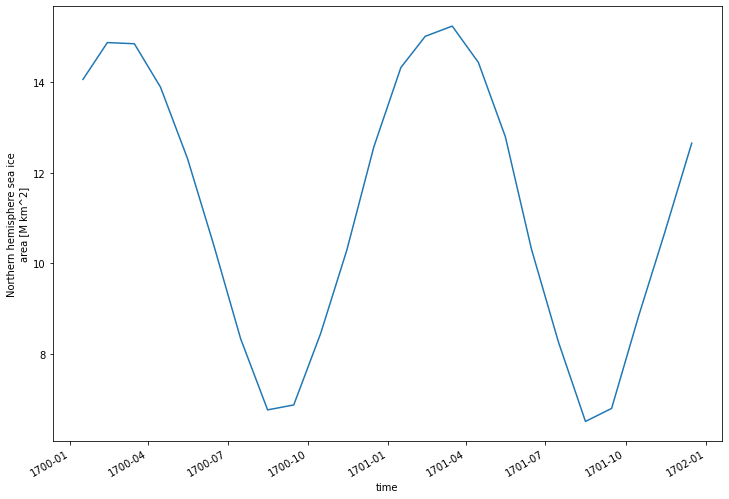

In [4]:
X_ds["ice_area"][:24].plot(size=8)

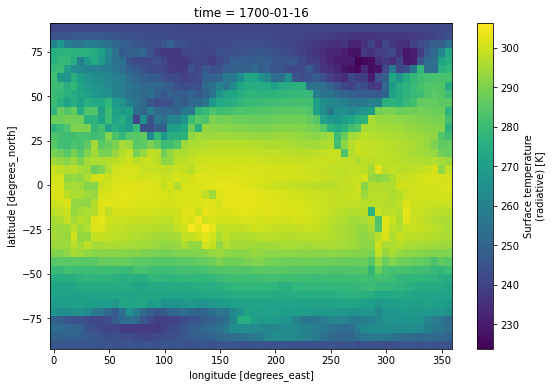

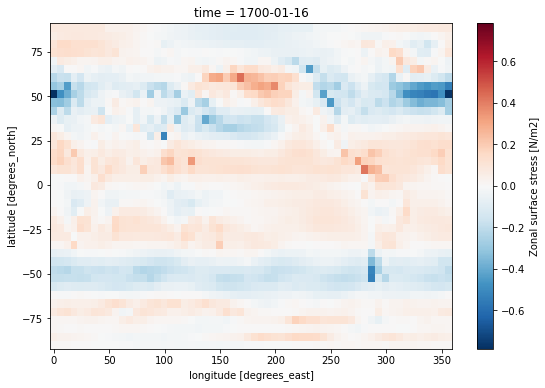

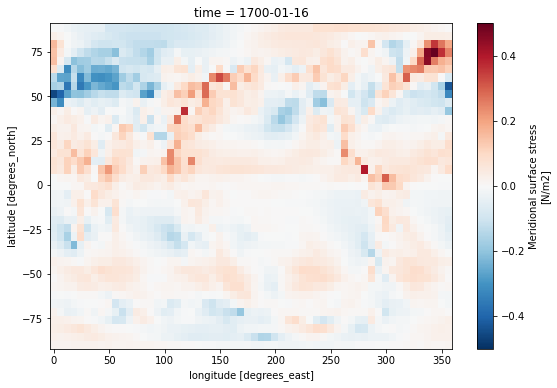

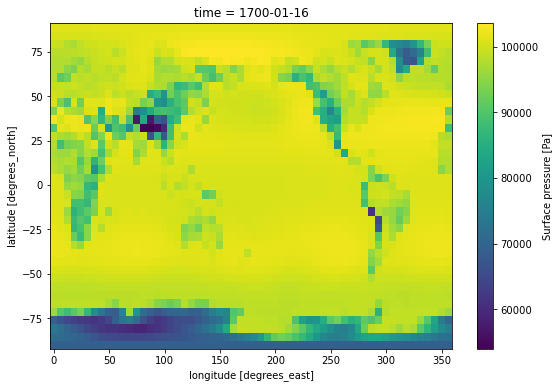

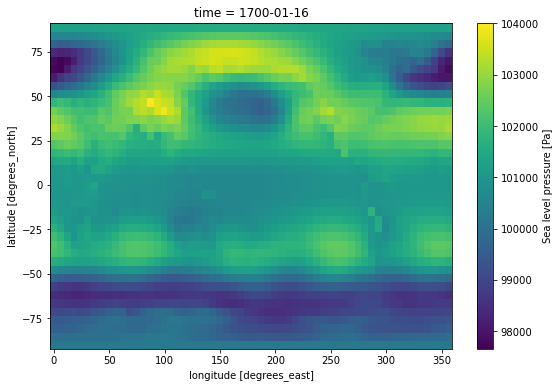

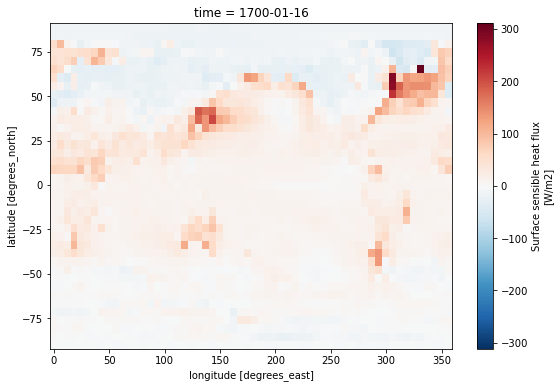

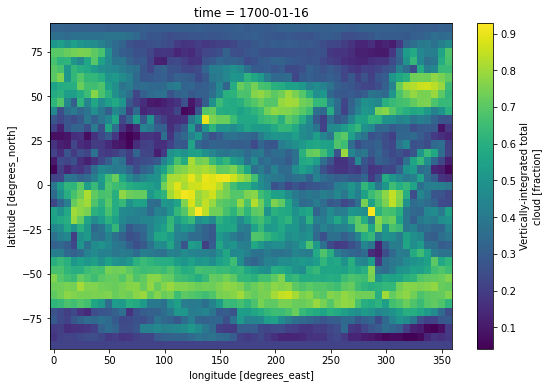

In [14]:
for i in list(X_ds.keys())[1:]:
    X_ds[i].isel(time=0).plot(size=6)
    plt.show()

In [4]:
X_ds.keys()

KeysView(<xarray.Dataset>
Dimensions:   (lat: 39, lon: 58, time: 1500)
Coordinates:
  * time      (time) datetime64[ns] 1700-01-16 1700-02-13 ... 1824-12-16
  * lat       (lat) float64 -90.0 -85.29 -80.58 -75.86 ... 79.63 84.35 89.06
  * lon       (lon) float64 0.0 6.25 12.5 18.75 25.0 ... 337.5 343.8 350.0 356.2
Data variables:
    ice_area  (time) float64 14.06 14.87 14.84 13.89 ... 7.397 9.453 11.09 13.21
    ts        (time, lat, lon) float32 ...
    taux      (time, lat, lon) float32 ...
    tauy      (time, lat, lon) float32 ...
    ps        (time, lat, lon) float32 ...
    psl       (time, lat, lon) float32 ...
    shflx     (time, lat, lon) float32 ...
    cldtot    (time, lat, lon) float32 ...
Attributes:
    n_burn_in:    120
    n_lookahead:  4)

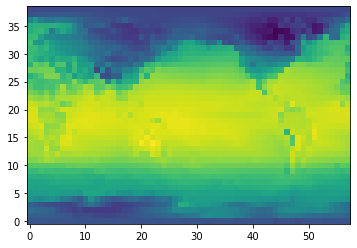

In [67]:
plt.imshow(X_ds["ts"].isel(time=0).values, origin='lower')

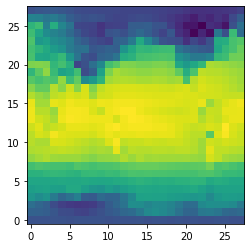

In [69]:
plt.imshow(np.array(scale(X_ds["ts"].values[0,:,:], 28, 28)) ,origin='lower')

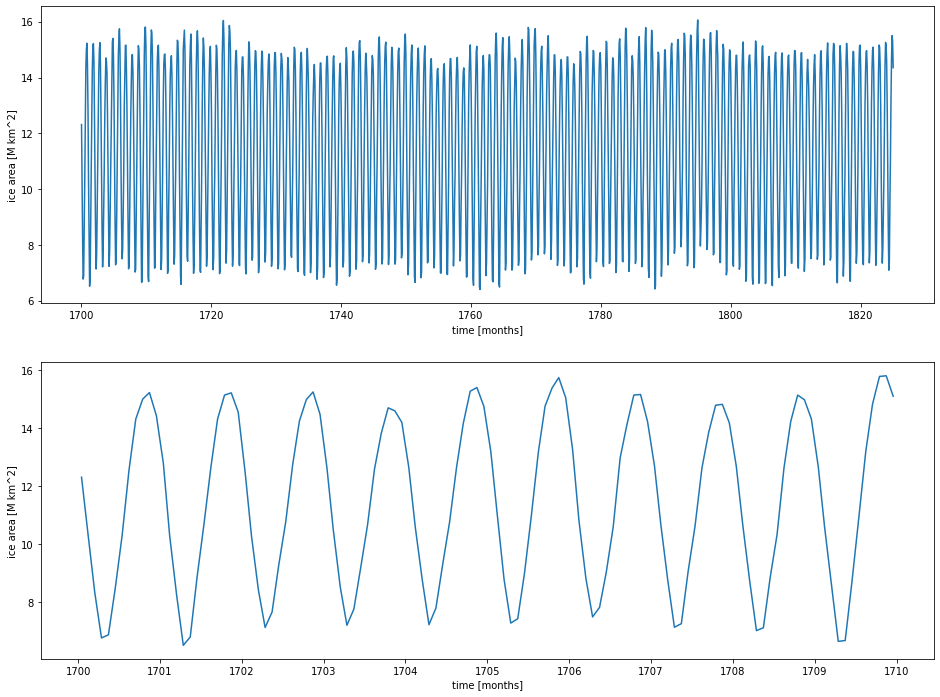

In [17]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(2, 1, 1)
ax.set_xlabel('time [months]')
ax.set_ylabel('ice area [M km^2]')
ax.plot(X_ds['time'], y_array)

ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('time [months]')
ax.set_ylabel('ice area [M km^2]')
ax.plot(X_ds['time'][:120], y_array[:120])

In [9]:
X_arr = np.array(X_ds.to_array())
X_arr = np.moveaxis(X_arr, 0, 3)
X_scaled = np.array(scale(X_arr, 28, 28))
X_scaled = np.moveaxis(X_scaled, 2, 0)

In [10]:
X_scaled.shape

(1500, 28, 28, 8)

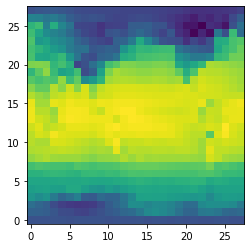

In [11]:
plt.imshow(X_scaled[0,:,:,1], origin="lower")

In [115]:
X_norm = normalize(X_scaled)

In [126]:
conv_model = CNNIce().initialize(X_norm.shape, 4, 3, 'relu')
learning_rate = 0.01
opt = Adam(lr=learning_rate)
conv_model.compile(opt, "mse")

In [127]:
conv_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 8)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 4)         292       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 4)         0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         296       
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 8)         0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 7, 7, 8)           0   

In [129]:
history = conv_model.fit(X_norm[:1440,:,:,:], y_array[:1440], batch_size=32, epochs=30, validation_data=(X_norm[1440:,:,:,:], y_array[1440:]),
                    verbose=1)

Epoch 1/30
45/45 [==============================] - 1s 21ms/step - loss: 44.9516 - val_loss: 8.9843
Epoch 2/30
45/45 [==============================] - 0s 11ms/step - loss: 7.6772 - val_loss: 7.3366
Epoch 3/30
45/45 [==============================] - 1s 25ms/step - loss: 6.4922 - val_loss: 6.1629
Epoch 4/30
45/45 [==============================] - 1s 14ms/step - loss: 6.2043 - val_loss: 6.1208
Epoch 5/30
45/45 [==============================] - 1s 14ms/step - loss: 6.6723 - val_loss: 5.3009
Epoch 6/30
45/45 [==============================] - 1s 14ms/step - loss: 5.2617 - val_loss: 4.2679
Epoch 7/30
45/45 [==============================] - 1s 12ms/step - loss: 4.0118 - val_loss: 1.6614
Epoch 8/30
45/45 [==============================] - 1s 14ms/step - loss: 1.4527 - val_loss: 0.4562
Epoch 9/30
45/45 [==============================] - 1s 12ms/step - loss: 0.5472 - val_loss: 0.5529
Epoch 10/30
45/45 [==============================] - 1s 15ms/step - loss: 0.7614 - val_loss: 0.3738
Epoch 11

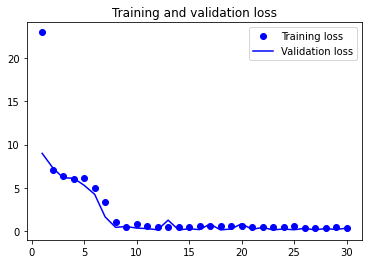

In [130]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

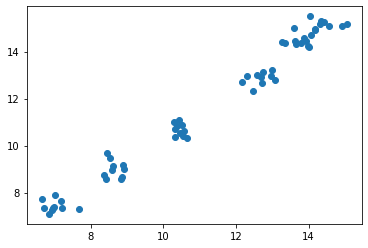

In [131]:
plt.scatter(conv_model.predict(X_norm[1440:,:,:,:]), y_array[1440:])

In [136]:
print("R2 = ", r_squared(y_array[1440:], conv_model.predict(X_norm[1440:,:,:,:]))[0])

R2 =  0.9541259


In [137]:
X_test = xr.open_dataset('./data/Ice/test.nc')
y_test = np.load('./data/Ice/test.npy') 

In [138]:
X_t = np.array(X_test.to_array())
X_t = np.moveaxis(X_t, 0, 3)
X_ts = np.array(scale(X_t, 28, 28))
X_ts = np.moveaxis(X_ts, 2, 0)

In [139]:
X_tn = normalize(X_ts)

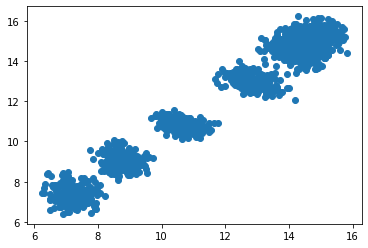

In [141]:
plt.scatter(conv_model.predict(X_tn), y_test)

In [142]:
print("R2 = ", r_squared(y_test, conv_model.predict(X_tn))[0])

R2 =  0.9490278


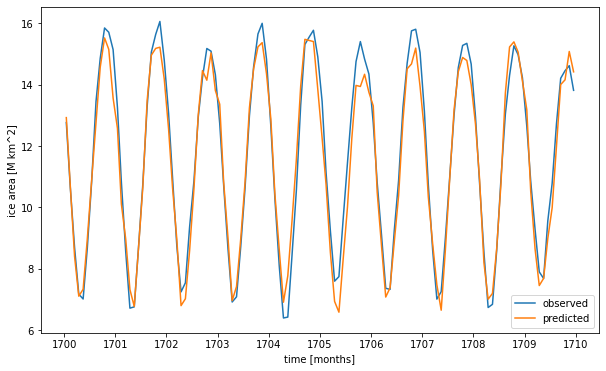

In [156]:
plt.figure(figsize=(10, 6))
plt.xlabel('time [months]')
plt.ylabel('ice area [M km^2]')
plt.plot(X_test['time'][:120], y_test[:120])
plt.plot(X_test['time'][:120], conv_model.predict(X_tn)[:120])
plt.legend(["observed", "predicted"])


In [166]:
xp = np.moveaxis(np.array(X_ds.to_array().values[1:,:,:,:]),0, 3)

In [181]:
np.expand_dims(xp, 4)[:,:,:,:,:].shape

(1500, 39, 58, 7, 1)

In [6]:
X_ds["ice_area"].values

array([14.05618858, 14.86767864, 14.84153461, ...,  9.45307636,
       11.09446239, 13.21102619])

In [5]:
prep = PreProc()

In [6]:
X_arr = np.array(X_ds.to_array()[1:,:,:,:])
X_arr = np.moveaxis(X_arr, 0, 3)
X_scaled = np.array(prep.scale(X_arr, 28, 28))
X_scaled = np.moveaxis(X_scaled, 2, 0)
X_vec = np.expand_dims(np.array(X_ds["ice_area"]), axis=1)

In [7]:
X_vec = (X_vec-X_vec.min())/(X_vec.max()-X_vec.min())

In [8]:
X_norm = prep.normalize(X_scaled)

In [9]:
conv_model1 = CNNIce1().initialize(X_norm.shape, X_vec.shape, 4, 3, 'relu')
learning_rate = 0.005
opt = Adam(lr=learning_rate)
conv_model1.compile(opt, "mse")

In [10]:
conv_model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 7)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 4)    256         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 4)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 14, 14, 4)    0           activation_1[0][0]               
______________________________________________________________________________________________

In [11]:
history = conv_model1.fit([X_norm[:1440,:,:,:], X_vec[:1440,:]], y_array[:1440], batch_size=32, epochs=30, 
                          validation_data=([X_norm[1440:,:,:,:], X_vec[1440:,:]], y_array[1440:]), verbose=1)

Epoch 1/30
45/45 [==============================] - 2s 29ms/step - loss: 49.8217 - val_loss: 8.2320
Epoch 2/30
45/45 [==============================] - 1s 13ms/step - loss: 8.4181 - val_loss: 7.9139
Epoch 3/30
45/45 [==============================] - 1s 16ms/step - loss: 8.1761 - val_loss: 8.3533
Epoch 4/30
45/45 [==============================] - 1s 20ms/step - loss: 8.5891 - val_loss: 8.5705
Epoch 5/30
45/45 [==============================] - 1s 13ms/step - loss: 8.5962 - val_loss: 7.5396
Epoch 6/30
45/45 [==============================] - 1s 14ms/step - loss: 7.8967 - val_loss: 7.2760
Epoch 7/30
45/45 [==============================] - 1s 13ms/step - loss: 6.7946 - val_loss: 4.0560
Epoch 8/30
45/45 [==============================] - 1s 13ms/step - loss: 3.4701 - val_loss: 1.5682
Epoch 9/30
45/45 [==============================] - 1s 22ms/step - loss: 1.4204 - val_loss: 1.0908
Epoch 10/30
45/45 [==============================] - 1s 16ms/step - loss: 1.1243 - val_loss: 0.7408
Epoch 11

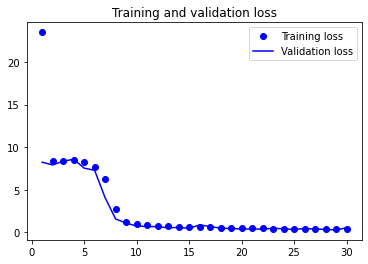

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

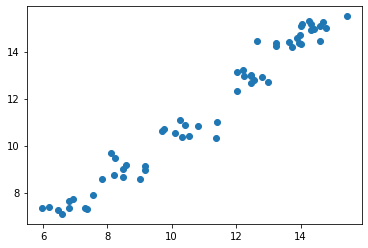

In [14]:
plt.scatter(conv_model1.predict([X_norm[1440:,:,:,:], X_vec[1440:,:]]), y_array[1440:])

In [16]:
print("R2 = ", r_squared(y_array[1440:], conv_model1.predict([X_norm[1440:,:,:,:], X_vec[1440:,:]]))[0])

R2 =  0.9322003
